In [1]:
# TO INSTALL pytorch3D TO COLAB
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.11.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

### CMPE538. Project 3.B

Fit sphere mesh (ico_sphere (res=4)) to our mesh object file'feed.obj'.
Use only "chamfer_distance", "mesh_laplacian_smoothing", "mesh_normal_consistency".
In this part, you are allowed to use built-in loss functions. 

Hint : https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

Please fill your info.

Name/Surname: Emre Girgin


E-mail: emre.girgin@boun.edu.tr

Student No: 2021700060

In [2]:
import argparse
import os
import time
import torch
import numpy as np

from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes

from tqdm.notebook import tqdm

from pytorch3d.structures import Meshes, Pointclouds 
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene

from pytorch3d.loss import (
    chamfer_distance,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

In [3]:
from pytorch3d.io import IO

device=torch.device("cuda:0")
my_mesh = IO().load_mesh("feed.obj", device=device)

sphere_mesh = ico_sphere(4, device)

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:530: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


In [4]:
# Ploty: "my_mesh" without background
fig = plot_scene({
    "subplot1": {
        "source_mesh": sphere_mesh
    },
     "subplot2": {
        "target_mesh": my_mesh
    }
})
fig.show()

# Your Part

In [5]:
# Fit the sphere mesh to given mesh object. You will do optimization. 

In [6]:
###################################################################
# HERE !
#

# Consider scaling 

"""
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale
"""

deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)


###################################################################

In [7]:
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss # MAYBE REMOVE ?
w_edge = 0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = sphere_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(my_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = 0 #mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    #edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    
    # Plot mesh
    #if i % plot_period == 0:
    #    plot_mesh(new_src_mesh)
        
    # Optimization step
    loss.backward()
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



In [8]:
fig = plot_scene({
     "Groundtruth": {
        "target_mesh": my_mesh
    },
    "Deformed": {
        "source_mesh": new_src_mesh
    }
})
fig.show()

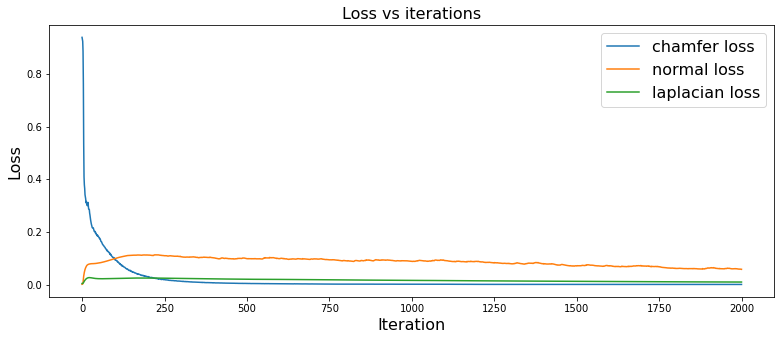

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
#ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

### References
1 -

2 -

3 -
